# Introduction

## World Food Programme (WFP) hackathon

This analysis is for the WFP hackathon organised by DataMission. See http://www.datamission.nl/un-world-food-program-hackathon/ for more info.

## Data

Info about available datasets is in the wiki, see https://github.com/datamission/WFP/wiki/Datasets-wiki-page. The wiki contains much more info, see https://github.com/datamission/WFP/wiki.


## Goals

In this notebook we try to achieve the following: 
* Gain insight into factors influencing Reduced Coping Strategy Index (rCSI) and Food Consumption Score (FCS). See https://github.com/datamission/WFP/wiki/List-of-Acronyms for definitions
* Predict rCSI and FCS on more granular spatial level than currently available

## Current Questions

* What is distribution of food scores vs region, income, city/rural area, ..?
* Should we work with aggregated food scores or more granular survey data?
* Filter/select regions with enough data before training ML models?


## Todo

* Preprocess
  * Gather data
  * Clean data
  * Merge data sets on region (where possible) 
* Exploratory Analysis
  * Plot indicators on map
  * Plot aggregated survey answers
  * Histogram/plot of aggregated survey answers vs indicators
* Inference
  * Check variance for indicators per region
  * Check number of data points per region
* Machine Learning
  * Regression problem (mean food score per region, percent below certain threshold per region?)
  * Convert to classification problem?
  * Potentially useful algoritms: Naive Bayes, Decision Tree, Random Forest, KNN, Linear Regression, SVM

# Preprocess

## Gather data

In [22]:
# Libraries
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import shapefile as shp

#from biokit.viz import corrplot
#from sklearn import tree
#import graphviz

# Inline plotting with specific image size
% matplotlib inline
pylab.rcParams['figure.figsize'] = 16, 12 

In [6]:
# Current dir
os.getcwd()

'/home/dennis/git/hackhunger/code'

In [39]:
# Data directories
dir_rainfall = "../data/yemen_rainfall/"
dir_yemen = "../data/USB/Yemen/"
dir_yemen_shapefiles = "../data/yemen_shapefiles/"

# Data files
file_foodprices_fao = dir_yemen + "YEM_FAO_FoodPrices.csv"
file_foodprices_wfp = dir_yemen + "YEM_WFP_FoodPrices_09-05-2016.csv"
file_marketlocations = dir_yemen + "YEM_WFP_Market-Locations.csv"
file_mvam = dir_yemen + "mVAM/Data/YEM_WFP_mVAM_RawData.csv"
file_cfss = dir_yemen + "CFSS/Data/YEM_CFSS_2014.csv"

# Shape files
file_shape = dir_yemen_shapefiles + "yem_bnd_adm2.shp"
file_shape_2 = dir_yemen_shapefiles + "yem_bnd_adm2"

In [8]:
# Read data
#df_foodprices_fao = pd.read_csv(file_foodprices_fao)   # Does not contain prices, only (irrelevant) commodity names
df_foodprices_wfp = pd.read_csv(file_foodprices_wfp)
df_marketlocations = pd.read_csv(file_marketlocations)
df_mvam = pd.read_csv(file_mvam)
# TODO: Error when reading cfss data
#df_cfss = pd.read_csv(file_cfss)

In [9]:
# Quickly explore data
#df_foodprices_wfp.head(3)
#df_mvam.head(3)
#df_mvam.columns
#df_mvam.size

## Clean

## Merge

# Exploratory Analysis

## Size of data sets

In [10]:
len(df_foodprices_wfp)

3919

In [11]:
len(df_mvam)

20484

In [12]:
len(df_marketlocations)

8

## Food Prices data histograms

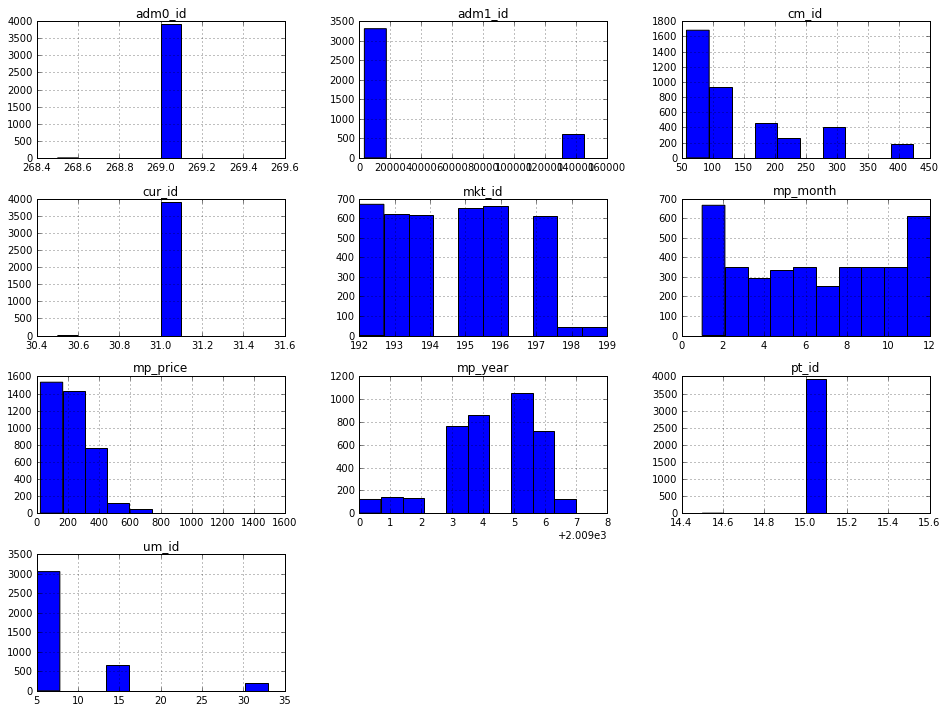

In [13]:
df_foodprices_wfp.hist();

## mVAM histograms

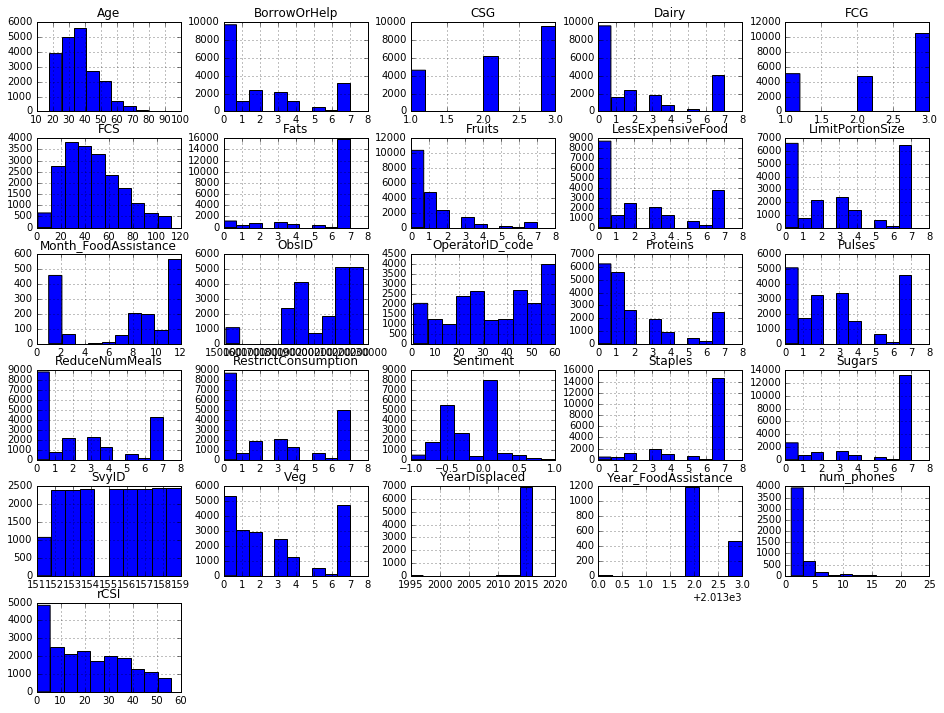

In [14]:
df_mvam.hist();

## Market Locations

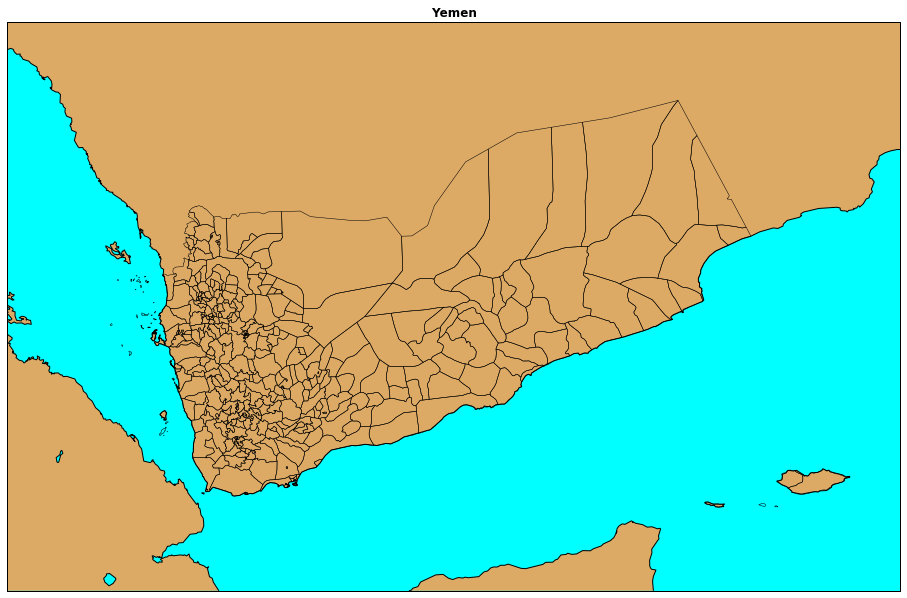

In [47]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(llcrnrlon=40,llcrnrlat=11,urcrnrlon=56,urcrnrlat=20,
             resolution='i', projection='tmerc', lat_0 = 11, lon_0 = 40)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='#ddaa66',lake_color='aqua')
map.drawcoastlines()

map.readshapefile(file_shape_2, 'yemen')

plt.title('Yemen', fontweight='bold')
plt.show()

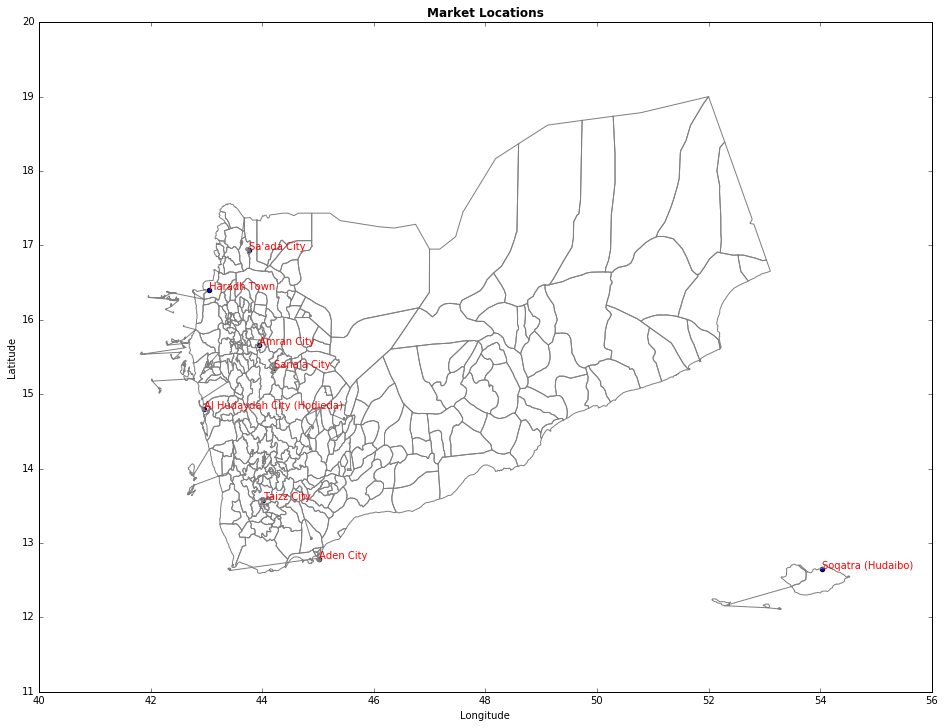

In [33]:
fig, ax = plt.subplots()
lng = df_marketlocations['mkt_lng']
lat = df_marketlocations['mkt_lat']
names = df_marketlocations['mkt_name']
sf = shp.Reader(file_shape)

# Plot shapefile
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, color='grey')

# Plot market locations
ax.scatter(lng, lat)

# Plot market names
for nr, name in enumerate(names):
    ax.annotate(name, (lng[nr],lat[nr]), color='red')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Market Locations', fontweight='bold')
plt.show()

# Inference

# Machine Learning